In [8]:
from functions import *

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# high quality figures 
plt.rcParams['figure.dpi'] = 300  # Higher DPI for better quality
plt.rcParams['figure.figsize'] = [3.5, 3.5]  # Smaller physical size but still high quality


#### **Modelling the Flache and Macy Model**

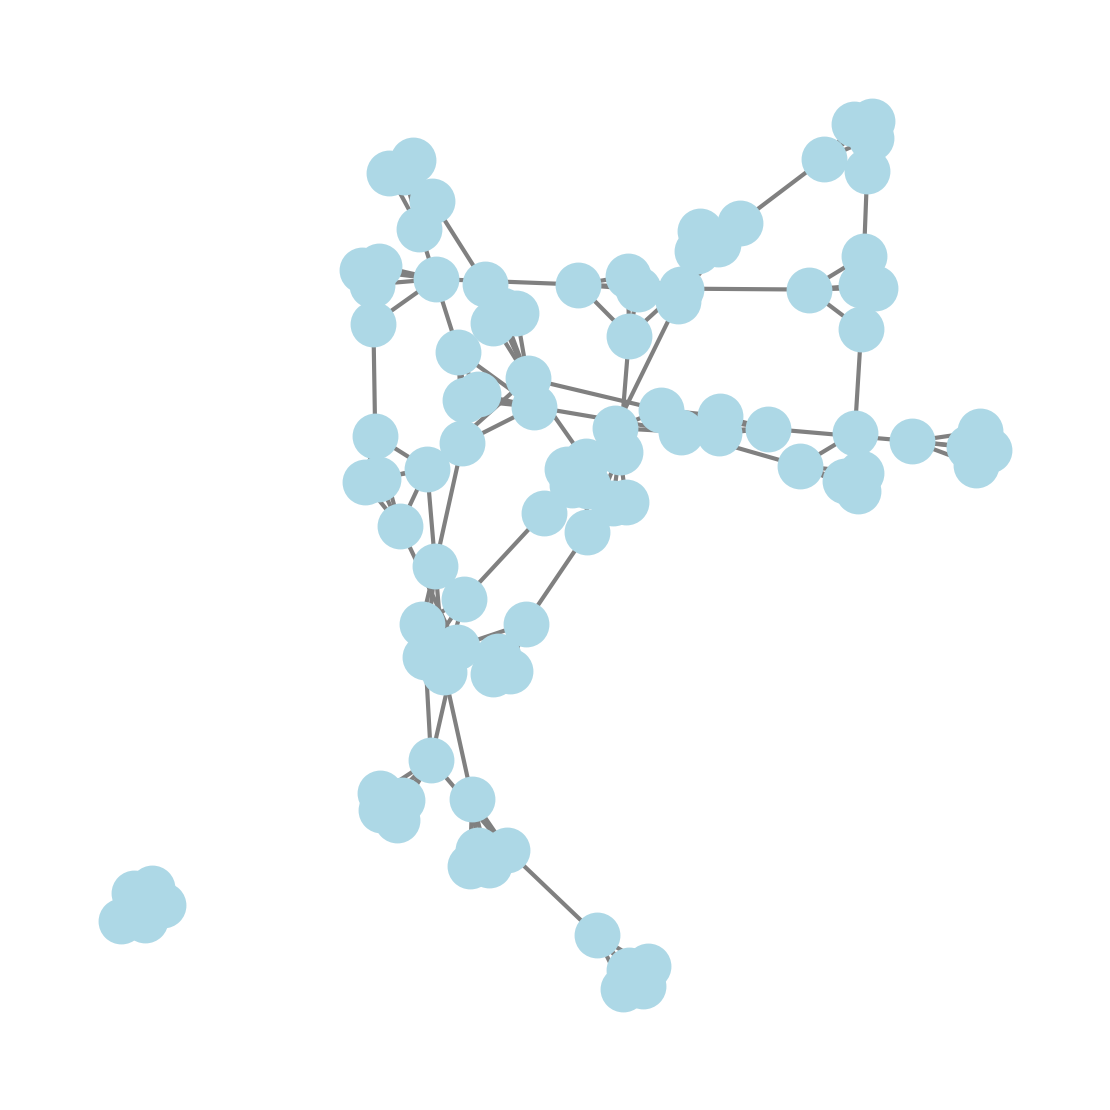

In [9]:
n_caves = 20  # number of groups 
n_members = 5   # number of nodes in each group

# create a cave-man network with 20 nodes in groups of 5
G = nx.connected_caveman_graph(n_caves, n_members)
G = initialize_network(n_caves, n_members, add_random_ties=True, p_random=0.003)

pos = nx.spring_layout(G)
nx.draw(G, pos = pos, with_labels=False, node_color='lightblue', node_size=100, edge_color='gray')
plt.show()